In [1]:
import torch
from torch import nn
import time
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue as prologue

In [2]:
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

In [3]:
print(train_input.shape)
print(train_classes.shape)
print(train_target.shape)
print(test_input.shape)
print(test_classes.shape)
print(test_target.shape)

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])
torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])


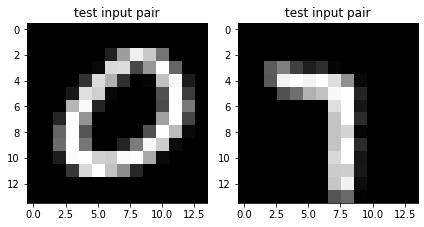

The test classes are: 0 and 7.
The test target is: 0


In [4]:
# discribe the data
fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(test_input[0][i], cmap='gray')
  plt.title("test input pair")  
  plt.tight_layout()
plt.show()
print("The test classes are: %d and %d."%(test_classes[0][0].item(),test_classes[0][1].item()))
print("The test target is: %d"%(train_target[0]))

In [5]:
# prepocess the training and testing data
tran_train_input=train_input.view([2000, 1, 14, 14])
tran_train_classes=train_classes.view([2000])
tran_test_input=test_input.view([2000, 1, 14, 14])
tran_test_classes=test_classes.view([2000])

In [6]:
#CNN
class CNN_one_by_one_Net(nn.Module):
    def __init__(self):
        super(CNN_one_by_one_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32,64,kernel_size=2)
        self.conv2_drop=nn.Dropout2d()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        x=self.conv1(x)
        x=F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(x)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = F.dropout(x,training=self.training)
        x = self.fc2(x)
        return x

        # Training Function

    def trainer(self, train_input, train_target):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        """
        start_time = time.time()
        self.train()
        for epoch in range(self.num_epochs):
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size]) 
                loss = self.criterion(output, train_target[batch_idx:batch_idx+self.batch_size])  
                self.optimizer.zero_grad()                          #set gradients to zero
                loss.backward()                                #backpropagate
                self.optimizer.step()
#                 Every 50 data, output loss once
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
        #test mode
        self.eval()
        outputs= self(input_data)
        _, predicted = torch.max(outputs, 1)
        return 1-self.compute_accuracy(target,predicted)
    
    def compute_accuracy(self, target, pred):
        """
        Compute the training and testing error
        :param target: target data (whether 1 or 0)
        :param pred: predicted data
        :return 
        """
        return (target-pred).eq(0).float().mean().item()
    
    def compare_two_digit(self, input_data, comp_targets):
        
        #test mode
        self.eval() 
        errors = 0
        for pairs,comp_target in zip(input_data, comp_targets):
            input_num1=pairs[0].view([1,1,14,14])
            input_num2=pairs[1].view([1,1,14,14])
            output_1 = self(input_num1)
            output_2 = self(input_num2)
            _, predicted_1 = torch.max(output_1, 1)   #return value and key
            _, predicted_2 = torch.max(output_2, 1)   #return value and key
            if(predicted_2-predicted_1>0):
                result=1
            else:
                result=0
            if(comp_target!=result):
                errors=errors+1
        return float(errors)/input_data.size(0)
        
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+ model_name)

In [7]:
my_model = CNN_one_by_one_Net()
my_model.save_model('CNN_one_by_one.pth')

In [8]:
# train the model
my_model.trainer(tran_train_input, tran_train_classes)

Epoch: 001/025 | Batch 000/2000 | Loss: 19.450377
Epoch: 001/025 | Batch 050/2000 | Loss: 15.340907
Epoch: 001/025 | Batch 100/2000 | Loss: 10.702032
Epoch: 001/025 | Batch 150/2000 | Loss: 9.274624
Epoch: 001/025 | Batch 200/2000 | Loss: 6.113512
Epoch: 001/025 | Batch 250/2000 | Loss: 4.894239
Epoch: 001/025 | Batch 300/2000 | Loss: 4.320829
Epoch: 001/025 | Batch 350/2000 | Loss: 3.719023
Epoch: 001/025 | Batch 400/2000 | Loss: 3.992105
Epoch: 001/025 | Batch 450/2000 | Loss: 2.759821
Epoch: 001/025 | Batch 500/2000 | Loss: 2.225543
Epoch: 001/025 | Batch 550/2000 | Loss: 2.600281
Epoch: 001/025 | Batch 600/2000 | Loss: 2.221360
Epoch: 001/025 | Batch 650/2000 | Loss: 2.084358
Epoch: 001/025 | Batch 700/2000 | Loss: 2.257531
Epoch: 001/025 | Batch 750/2000 | Loss: 1.609985
Epoch: 001/025 | Batch 800/2000 | Loss: 2.169423
Epoch: 001/025 | Batch 850/2000 | Loss: 1.759455
Epoch: 001/025 | Batch 900/2000 | Loss: 1.756933
Epoch: 001/025 | Batch 950/2000 | Loss: 1.804319
Epoch: 001/025 | 

Epoch: 005/025 | Batch 650/2000 | Loss: 0.461794
Epoch: 005/025 | Batch 700/2000 | Loss: 0.425479
Epoch: 005/025 | Batch 750/2000 | Loss: 0.289369
Epoch: 005/025 | Batch 800/2000 | Loss: 0.449857
Epoch: 005/025 | Batch 850/2000 | Loss: 0.688620
Epoch: 005/025 | Batch 900/2000 | Loss: 0.538047
Epoch: 005/025 | Batch 950/2000 | Loss: 0.596756
Epoch: 005/025 | Batch 1000/2000 | Loss: 0.211514
Epoch: 005/025 | Batch 1050/2000 | Loss: 0.383994
Epoch: 005/025 | Batch 1100/2000 | Loss: 0.786357
Epoch: 005/025 | Batch 1150/2000 | Loss: 0.275729
Epoch: 005/025 | Batch 1200/2000 | Loss: 0.280727
Epoch: 005/025 | Batch 1250/2000 | Loss: 0.497825
Epoch: 005/025 | Batch 1300/2000 | Loss: 0.303806
Epoch: 005/025 | Batch 1350/2000 | Loss: 0.210041
Epoch: 005/025 | Batch 1400/2000 | Loss: 0.236288
Epoch: 005/025 | Batch 1450/2000 | Loss: 0.484620
Epoch: 005/025 | Batch 1500/2000 | Loss: 0.329298
Epoch: 005/025 | Batch 1550/2000 | Loss: 0.307191
Epoch: 005/025 | Batch 1600/2000 | Loss: 0.299867
Epoch: 

Epoch: 009/025 | Batch 1400/2000 | Loss: 0.101221
Epoch: 009/025 | Batch 1450/2000 | Loss: 0.334707
Epoch: 009/025 | Batch 1500/2000 | Loss: 0.063627
Epoch: 009/025 | Batch 1550/2000 | Loss: 0.233870
Epoch: 009/025 | Batch 1600/2000 | Loss: 0.177121
Epoch: 009/025 | Batch 1650/2000 | Loss: 0.179974
Epoch: 009/025 | Batch 1700/2000 | Loss: 0.215635
Epoch: 009/025 | Batch 1750/2000 | Loss: 0.128381
Epoch: 009/025 | Batch 1800/2000 | Loss: 0.251966
Epoch: 009/025 | Batch 1850/2000 | Loss: 0.086034
Epoch: 009/025 | Batch 1900/2000 | Loss: 0.283387
Epoch: 009/025 | Batch 1950/2000 | Loss: 0.222767
Time elapsed: 0.03 min
Epoch: 010/025 | Batch 000/2000 | Loss: 0.292315
Epoch: 010/025 | Batch 050/2000 | Loss: 0.231154
Epoch: 010/025 | Batch 100/2000 | Loss: 0.142146
Epoch: 010/025 | Batch 150/2000 | Loss: 0.267221
Epoch: 010/025 | Batch 200/2000 | Loss: 0.111383
Epoch: 010/025 | Batch 250/2000 | Loss: 0.146380
Epoch: 010/025 | Batch 300/2000 | Loss: 0.119677
Epoch: 010/025 | Batch 350/2000 | 

Epoch: 014/025 | Batch 400/2000 | Loss: 0.135646
Epoch: 014/025 | Batch 450/2000 | Loss: 0.124495
Epoch: 014/025 | Batch 500/2000 | Loss: 0.039118
Epoch: 014/025 | Batch 550/2000 | Loss: 0.081540
Epoch: 014/025 | Batch 600/2000 | Loss: 0.034076
Epoch: 014/025 | Batch 650/2000 | Loss: 0.119197
Epoch: 014/025 | Batch 700/2000 | Loss: 0.099003
Epoch: 014/025 | Batch 750/2000 | Loss: 0.086761
Epoch: 014/025 | Batch 800/2000 | Loss: 0.264880
Epoch: 014/025 | Batch 850/2000 | Loss: 0.309635
Epoch: 014/025 | Batch 900/2000 | Loss: 0.164365
Epoch: 014/025 | Batch 950/2000 | Loss: 0.033443
Epoch: 014/025 | Batch 1000/2000 | Loss: 0.076352
Epoch: 014/025 | Batch 1050/2000 | Loss: 0.117286
Epoch: 014/025 | Batch 1100/2000 | Loss: 0.411965
Epoch: 014/025 | Batch 1150/2000 | Loss: 0.103529
Epoch: 014/025 | Batch 1200/2000 | Loss: 0.026285
Epoch: 014/025 | Batch 1250/2000 | Loss: 0.132052
Epoch: 014/025 | Batch 1300/2000 | Loss: 0.078588
Epoch: 014/025 | Batch 1350/2000 | Loss: 0.030437
Epoch: 014/0

Epoch: 019/025 | Batch 100/2000 | Loss: 0.037576
Epoch: 019/025 | Batch 150/2000 | Loss: 0.050824
Epoch: 019/025 | Batch 200/2000 | Loss: 0.018089
Epoch: 019/025 | Batch 250/2000 | Loss: 0.153371
Epoch: 019/025 | Batch 300/2000 | Loss: 0.194485
Epoch: 019/025 | Batch 350/2000 | Loss: 0.086737
Epoch: 019/025 | Batch 400/2000 | Loss: 0.142154
Epoch: 019/025 | Batch 450/2000 | Loss: 0.199904
Epoch: 019/025 | Batch 500/2000 | Loss: 0.081133
Epoch: 019/025 | Batch 550/2000 | Loss: 0.065854
Epoch: 019/025 | Batch 600/2000 | Loss: 0.045841
Epoch: 019/025 | Batch 650/2000 | Loss: 0.104813
Epoch: 019/025 | Batch 700/2000 | Loss: 0.127022
Epoch: 019/025 | Batch 750/2000 | Loss: 0.042452
Epoch: 019/025 | Batch 800/2000 | Loss: 0.027135
Epoch: 019/025 | Batch 850/2000 | Loss: 0.055367
Epoch: 019/025 | Batch 900/2000 | Loss: 0.091631
Epoch: 019/025 | Batch 950/2000 | Loss: 0.024216
Epoch: 019/025 | Batch 1000/2000 | Loss: 0.221243
Epoch: 019/025 | Batch 1050/2000 | Loss: 0.251071
Epoch: 019/025 | B

Epoch: 023/025 | Batch 1600/2000 | Loss: 0.090066
Epoch: 023/025 | Batch 1650/2000 | Loss: 0.042100
Epoch: 023/025 | Batch 1700/2000 | Loss: 0.066323
Epoch: 023/025 | Batch 1750/2000 | Loss: 0.043314
Epoch: 023/025 | Batch 1800/2000 | Loss: 0.042532
Epoch: 023/025 | Batch 1850/2000 | Loss: 0.008017
Epoch: 023/025 | Batch 1900/2000 | Loss: 0.110484
Epoch: 023/025 | Batch 1950/2000 | Loss: 0.058898
Time elapsed: 0.09 min
Epoch: 024/025 | Batch 000/2000 | Loss: 0.278125
Epoch: 024/025 | Batch 050/2000 | Loss: 0.023947
Epoch: 024/025 | Batch 100/2000 | Loss: 0.127238
Epoch: 024/025 | Batch 150/2000 | Loss: 0.025445
Epoch: 024/025 | Batch 200/2000 | Loss: 0.019840
Epoch: 024/025 | Batch 250/2000 | Loss: 0.053914
Epoch: 024/025 | Batch 300/2000 | Loss: 0.107924
Epoch: 024/025 | Batch 350/2000 | Loss: 0.057200
Epoch: 024/025 | Batch 400/2000 | Loss: 0.071698
Epoch: 024/025 | Batch 450/2000 | Loss: 0.063046
Epoch: 024/025 | Batch 500/2000 | Loss: 0.127530
Epoch: 024/025 | Batch 550/2000 | Loss

In [9]:
# output the number of parameters
print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

The total number of the parameters is: 43274


Now, we have trained a model to figure out what a number is, then I can apply this model to compare the number pairs.

The advantage of this method is we can split the 1000 pairs of data into 2000 data. Written digital number recognition has acquired very high accuracy, so we are going to firstly recognize the numbers and then then compare them. Finally, we compare the results with the targets.

In [10]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = CNN_one_by_one_Net()
    # train the model
    my_model.trainer(tran_train_input, tran_train_classes)
    train_errors.append(my_model.compare_two_digit(train_input,train_target))
    test_errors.append(my_model.compare_two_digit(test_input,test_target))

Epoch: 001/025 | Batch 000/2000 | Loss: 21.825628
Epoch: 001/025 | Batch 050/2000 | Loss: 16.283987
Epoch: 001/025 | Batch 100/2000 | Loss: 14.304948
Epoch: 001/025 | Batch 150/2000 | Loss: 10.776364
Epoch: 001/025 | Batch 200/2000 | Loss: 7.925897
Epoch: 001/025 | Batch 250/2000 | Loss: 6.538376
Epoch: 001/025 | Batch 300/2000 | Loss: 6.739304
Epoch: 001/025 | Batch 350/2000 | Loss: 5.276495
Epoch: 001/025 | Batch 400/2000 | Loss: 4.433125
Epoch: 001/025 | Batch 450/2000 | Loss: 2.791129
Epoch: 001/025 | Batch 500/2000 | Loss: 2.313843
Epoch: 001/025 | Batch 550/2000 | Loss: 1.773129
Epoch: 001/025 | Batch 600/2000 | Loss: 2.424668
Epoch: 001/025 | Batch 650/2000 | Loss: 2.106369
Epoch: 001/025 | Batch 700/2000 | Loss: 1.959430
Epoch: 001/025 | Batch 750/2000 | Loss: 1.946793
Epoch: 001/025 | Batch 800/2000 | Loss: 1.891936
Epoch: 001/025 | Batch 850/2000 | Loss: 1.870067
Epoch: 001/025 | Batch 900/2000 | Loss: 1.966075
Epoch: 001/025 | Batch 950/2000 | Loss: 1.762508
Epoch: 001/025 |

Epoch: 005/025 | Batch 1500/2000 | Loss: 0.511804
Epoch: 005/025 | Batch 1550/2000 | Loss: 0.777457
Epoch: 005/025 | Batch 1600/2000 | Loss: 0.465626
Epoch: 005/025 | Batch 1650/2000 | Loss: 0.478866
Epoch: 005/025 | Batch 1700/2000 | Loss: 0.631485
Epoch: 005/025 | Batch 1750/2000 | Loss: 0.550297
Epoch: 005/025 | Batch 1800/2000 | Loss: 0.495417
Epoch: 005/025 | Batch 1850/2000 | Loss: 0.413295
Epoch: 005/025 | Batch 1900/2000 | Loss: 0.441757
Epoch: 005/025 | Batch 1950/2000 | Loss: 0.401412
Time elapsed: 0.02 min
Epoch: 006/025 | Batch 000/2000 | Loss: 0.636869
Epoch: 006/025 | Batch 050/2000 | Loss: 0.588720
Epoch: 006/025 | Batch 100/2000 | Loss: 0.430803
Epoch: 006/025 | Batch 150/2000 | Loss: 0.360235
Epoch: 006/025 | Batch 200/2000 | Loss: 0.321267
Epoch: 006/025 | Batch 250/2000 | Loss: 0.314729
Epoch: 006/025 | Batch 300/2000 | Loss: 0.424031
Epoch: 006/025 | Batch 350/2000 | Loss: 0.573940
Epoch: 006/025 | Batch 400/2000 | Loss: 0.223119
Epoch: 006/025 | Batch 450/2000 | Lo

Epoch: 010/025 | Batch 900/2000 | Loss: 0.405388
Epoch: 010/025 | Batch 950/2000 | Loss: 0.421844
Epoch: 010/025 | Batch 1000/2000 | Loss: 0.360605
Epoch: 010/025 | Batch 1050/2000 | Loss: 0.375003
Epoch: 010/025 | Batch 1100/2000 | Loss: 0.540632
Epoch: 010/025 | Batch 1150/2000 | Loss: 0.210386
Epoch: 010/025 | Batch 1200/2000 | Loss: 0.246004
Epoch: 010/025 | Batch 1250/2000 | Loss: 0.208440
Epoch: 010/025 | Batch 1300/2000 | Loss: 0.229423
Epoch: 010/025 | Batch 1350/2000 | Loss: 0.184530
Epoch: 010/025 | Batch 1400/2000 | Loss: 0.214485
Epoch: 010/025 | Batch 1450/2000 | Loss: 0.415219
Epoch: 010/025 | Batch 1500/2000 | Loss: 0.103927
Epoch: 010/025 | Batch 1550/2000 | Loss: 0.247239
Epoch: 010/025 | Batch 1600/2000 | Loss: 0.227331
Epoch: 010/025 | Batch 1650/2000 | Loss: 0.404364
Epoch: 010/025 | Batch 1700/2000 | Loss: 0.491720
Epoch: 010/025 | Batch 1750/2000 | Loss: 0.391388
Epoch: 010/025 | Batch 1800/2000 | Loss: 0.231205
Epoch: 010/025 | Batch 1850/2000 | Loss: 0.170393
Ep

Epoch: 015/025 | Batch 150/2000 | Loss: 0.119901
Epoch: 015/025 | Batch 200/2000 | Loss: 0.077077
Epoch: 015/025 | Batch 250/2000 | Loss: 0.181741
Epoch: 015/025 | Batch 300/2000 | Loss: 0.178410
Epoch: 015/025 | Batch 350/2000 | Loss: 0.188028
Epoch: 015/025 | Batch 400/2000 | Loss: 0.075480
Epoch: 015/025 | Batch 450/2000 | Loss: 0.160160
Epoch: 015/025 | Batch 500/2000 | Loss: 0.115699
Epoch: 015/025 | Batch 550/2000 | Loss: 0.224965
Epoch: 015/025 | Batch 600/2000 | Loss: 0.151342
Epoch: 015/025 | Batch 650/2000 | Loss: 0.138167
Epoch: 015/025 | Batch 700/2000 | Loss: 0.205561
Epoch: 015/025 | Batch 750/2000 | Loss: 0.126094
Epoch: 015/025 | Batch 800/2000 | Loss: 0.226249
Epoch: 015/025 | Batch 850/2000 | Loss: 0.197611
Epoch: 015/025 | Batch 900/2000 | Loss: 0.227567
Epoch: 015/025 | Batch 950/2000 | Loss: 0.313206
Epoch: 015/025 | Batch 1000/2000 | Loss: 0.093682
Epoch: 015/025 | Batch 1050/2000 | Loss: 0.127323
Epoch: 015/025 | Batch 1100/2000 | Loss: 0.315766
Epoch: 015/025 | 

Epoch: 019/025 | Batch 1650/2000 | Loss: 0.042079
Epoch: 019/025 | Batch 1700/2000 | Loss: 0.232649
Epoch: 019/025 | Batch 1750/2000 | Loss: 0.111257
Epoch: 019/025 | Batch 1800/2000 | Loss: 0.038404
Epoch: 019/025 | Batch 1850/2000 | Loss: 0.074842
Epoch: 019/025 | Batch 1900/2000 | Loss: 0.044051
Epoch: 019/025 | Batch 1950/2000 | Loss: 0.129158
Time elapsed: 0.07 min
Epoch: 020/025 | Batch 000/2000 | Loss: 0.119472
Epoch: 020/025 | Batch 050/2000 | Loss: 0.080789
Epoch: 020/025 | Batch 100/2000 | Loss: 0.089712
Epoch: 020/025 | Batch 150/2000 | Loss: 0.036329
Epoch: 020/025 | Batch 200/2000 | Loss: 0.154005
Epoch: 020/025 | Batch 250/2000 | Loss: 0.055625
Epoch: 020/025 | Batch 300/2000 | Loss: 0.064635
Epoch: 020/025 | Batch 350/2000 | Loss: 0.118374
Epoch: 020/025 | Batch 400/2000 | Loss: 0.082116
Epoch: 020/025 | Batch 450/2000 | Loss: 0.077126
Epoch: 020/025 | Batch 500/2000 | Loss: 0.088789
Epoch: 020/025 | Batch 550/2000 | Loss: 0.082680
Epoch: 020/025 | Batch 600/2000 | Loss:

Epoch: 024/025 | Batch 1000/2000 | Loss: 0.121258
Epoch: 024/025 | Batch 1050/2000 | Loss: 0.040968
Epoch: 024/025 | Batch 1100/2000 | Loss: 0.116422
Epoch: 024/025 | Batch 1150/2000 | Loss: 0.066332
Epoch: 024/025 | Batch 1200/2000 | Loss: 0.007131
Epoch: 024/025 | Batch 1250/2000 | Loss: 0.072546
Epoch: 024/025 | Batch 1300/2000 | Loss: 0.074539
Epoch: 024/025 | Batch 1350/2000 | Loss: 0.010975
Epoch: 024/025 | Batch 1400/2000 | Loss: 0.087619
Epoch: 024/025 | Batch 1450/2000 | Loss: 0.071428
Epoch: 024/025 | Batch 1500/2000 | Loss: 0.098195
Epoch: 024/025 | Batch 1550/2000 | Loss: 0.050962
Epoch: 024/025 | Batch 1600/2000 | Loss: 0.032998
Epoch: 024/025 | Batch 1650/2000 | Loss: 0.095684
Epoch: 024/025 | Batch 1700/2000 | Loss: 0.055974
Epoch: 024/025 | Batch 1750/2000 | Loss: 0.077989
Epoch: 024/025 | Batch 1800/2000 | Loss: 0.102622
Epoch: 024/025 | Batch 1850/2000 | Loss: 0.058071
Epoch: 024/025 | Batch 1900/2000 | Loss: 0.057771
Epoch: 024/025 | Batch 1950/2000 | Loss: 0.016617


Epoch: 004/025 | Batch 850/2000 | Loss: 1.053000
Epoch: 004/025 | Batch 900/2000 | Loss: 0.894578
Epoch: 004/025 | Batch 950/2000 | Loss: 0.660940
Epoch: 004/025 | Batch 1000/2000 | Loss: 0.763969
Epoch: 004/025 | Batch 1050/2000 | Loss: 0.901542
Epoch: 004/025 | Batch 1100/2000 | Loss: 1.530133
Epoch: 004/025 | Batch 1150/2000 | Loss: 0.848631
Epoch: 004/025 | Batch 1200/2000 | Loss: 1.106767
Epoch: 004/025 | Batch 1250/2000 | Loss: 0.924861
Epoch: 004/025 | Batch 1300/2000 | Loss: 1.027509
Epoch: 004/025 | Batch 1350/2000 | Loss: 0.714588
Epoch: 004/025 | Batch 1400/2000 | Loss: 0.746279
Epoch: 004/025 | Batch 1450/2000 | Loss: 0.622509
Epoch: 004/025 | Batch 1500/2000 | Loss: 0.814630
Epoch: 004/025 | Batch 1550/2000 | Loss: 1.041746
Epoch: 004/025 | Batch 1600/2000 | Loss: 0.613379
Epoch: 004/025 | Batch 1650/2000 | Loss: 0.752725
Epoch: 004/025 | Batch 1700/2000 | Loss: 0.953114
Epoch: 004/025 | Batch 1750/2000 | Loss: 0.939642
Epoch: 004/025 | Batch 1800/2000 | Loss: 0.811206
Epo

Epoch: 008/025 | Batch 1100/2000 | Loss: 0.813243
Epoch: 008/025 | Batch 1150/2000 | Loss: 0.207794
Epoch: 008/025 | Batch 1200/2000 | Loss: 0.443160
Epoch: 008/025 | Batch 1250/2000 | Loss: 0.742317
Epoch: 008/025 | Batch 1300/2000 | Loss: 0.342402
Epoch: 008/025 | Batch 1350/2000 | Loss: 0.321444
Epoch: 008/025 | Batch 1400/2000 | Loss: 0.335327
Epoch: 008/025 | Batch 1450/2000 | Loss: 0.424943
Epoch: 008/025 | Batch 1500/2000 | Loss: 0.295078
Epoch: 008/025 | Batch 1550/2000 | Loss: 0.612506
Epoch: 008/025 | Batch 1600/2000 | Loss: 0.424694
Epoch: 008/025 | Batch 1650/2000 | Loss: 0.326472
Epoch: 008/025 | Batch 1700/2000 | Loss: 0.211534
Epoch: 008/025 | Batch 1750/2000 | Loss: 0.387005
Epoch: 008/025 | Batch 1800/2000 | Loss: 0.492011
Epoch: 008/025 | Batch 1850/2000 | Loss: 0.394558
Epoch: 008/025 | Batch 1900/2000 | Loss: 0.401086
Epoch: 008/025 | Batch 1950/2000 | Loss: 0.535334
Time elapsed: 0.03 min
Epoch: 009/025 | Batch 000/2000 | Loss: 0.478011
Epoch: 009/025 | Batch 050/2

Epoch: 012/025 | Batch 1550/2000 | Loss: 0.292467
Epoch: 012/025 | Batch 1600/2000 | Loss: 0.298890
Epoch: 012/025 | Batch 1650/2000 | Loss: 0.252155
Epoch: 012/025 | Batch 1700/2000 | Loss: 0.368108
Epoch: 012/025 | Batch 1750/2000 | Loss: 0.293098
Epoch: 012/025 | Batch 1800/2000 | Loss: 0.299011
Epoch: 012/025 | Batch 1850/2000 | Loss: 0.165121
Epoch: 012/025 | Batch 1900/2000 | Loss: 0.308154
Epoch: 012/025 | Batch 1950/2000 | Loss: 0.200045
Time elapsed: 0.05 min
Epoch: 013/025 | Batch 000/2000 | Loss: 0.380577
Epoch: 013/025 | Batch 050/2000 | Loss: 0.247275
Epoch: 013/025 | Batch 100/2000 | Loss: 0.265122
Epoch: 013/025 | Batch 150/2000 | Loss: 0.139564
Epoch: 013/025 | Batch 200/2000 | Loss: 0.112651
Epoch: 013/025 | Batch 250/2000 | Loss: 0.200819
Epoch: 013/025 | Batch 300/2000 | Loss: 0.162553
Epoch: 013/025 | Batch 350/2000 | Loss: 0.314817
Epoch: 013/025 | Batch 400/2000 | Loss: 0.069811
Epoch: 013/025 | Batch 450/2000 | Loss: 0.319822
Epoch: 013/025 | Batch 500/2000 | Los

Epoch: 017/025 | Batch 350/2000 | Loss: 0.151124
Epoch: 017/025 | Batch 400/2000 | Loss: 0.087440
Epoch: 017/025 | Batch 450/2000 | Loss: 0.201847
Epoch: 017/025 | Batch 500/2000 | Loss: 0.119369
Epoch: 017/025 | Batch 550/2000 | Loss: 0.115267
Epoch: 017/025 | Batch 600/2000 | Loss: 0.071083
Epoch: 017/025 | Batch 650/2000 | Loss: 0.139432
Epoch: 017/025 | Batch 700/2000 | Loss: 0.056876
Epoch: 017/025 | Batch 750/2000 | Loss: 0.069295
Epoch: 017/025 | Batch 800/2000 | Loss: 0.224634
Epoch: 017/025 | Batch 850/2000 | Loss: 0.196161
Epoch: 017/025 | Batch 900/2000 | Loss: 0.387726
Epoch: 017/025 | Batch 950/2000 | Loss: 0.210377
Epoch: 017/025 | Batch 1000/2000 | Loss: 0.206266
Epoch: 017/025 | Batch 1050/2000 | Loss: 0.173468
Epoch: 017/025 | Batch 1100/2000 | Loss: 0.309207
Epoch: 017/025 | Batch 1150/2000 | Loss: 0.045863
Epoch: 017/025 | Batch 1200/2000 | Loss: 0.098564
Epoch: 017/025 | Batch 1250/2000 | Loss: 0.108917
Epoch: 017/025 | Batch 1300/2000 | Loss: 0.028105
Epoch: 017/02

Epoch: 021/025 | Batch 550/2000 | Loss: 0.102284
Epoch: 021/025 | Batch 600/2000 | Loss: 0.045583
Epoch: 021/025 | Batch 650/2000 | Loss: 0.218267
Epoch: 021/025 | Batch 700/2000 | Loss: 0.142522
Epoch: 021/025 | Batch 750/2000 | Loss: 0.104812
Epoch: 021/025 | Batch 800/2000 | Loss: 0.213570
Epoch: 021/025 | Batch 850/2000 | Loss: 0.061561
Epoch: 021/025 | Batch 900/2000 | Loss: 0.297869
Epoch: 021/025 | Batch 950/2000 | Loss: 0.120000
Epoch: 021/025 | Batch 1000/2000 | Loss: 0.146780
Epoch: 021/025 | Batch 1050/2000 | Loss: 0.265397
Epoch: 021/025 | Batch 1100/2000 | Loss: 0.174898
Epoch: 021/025 | Batch 1150/2000 | Loss: 0.035537
Epoch: 021/025 | Batch 1200/2000 | Loss: 0.127585
Epoch: 021/025 | Batch 1250/2000 | Loss: 0.290572
Epoch: 021/025 | Batch 1300/2000 | Loss: 0.060434
Epoch: 021/025 | Batch 1350/2000 | Loss: 0.107826
Epoch: 021/025 | Batch 1400/2000 | Loss: 0.144203
Epoch: 021/025 | Batch 1450/2000 | Loss: 0.174331
Epoch: 021/025 | Batch 1500/2000 | Loss: 0.083923
Epoch: 02

Epoch: 025/025 | Batch 1500/2000 | Loss: 0.017086
Epoch: 025/025 | Batch 1550/2000 | Loss: 0.060676
Epoch: 025/025 | Batch 1600/2000 | Loss: 0.017227
Epoch: 025/025 | Batch 1650/2000 | Loss: 0.043658
Epoch: 025/025 | Batch 1700/2000 | Loss: 0.140256
Epoch: 025/025 | Batch 1750/2000 | Loss: 0.040570
Epoch: 025/025 | Batch 1800/2000 | Loss: 0.086073
Epoch: 025/025 | Batch 1850/2000 | Loss: 0.150411
Epoch: 025/025 | Batch 1900/2000 | Loss: 0.040533
Epoch: 025/025 | Batch 1950/2000 | Loss: 0.154752
Time elapsed: 0.11 min
Total Training Time: 0.11 min
Epoch: 001/025 | Batch 000/2000 | Loss: 16.261360
Epoch: 001/025 | Batch 050/2000 | Loss: 13.414975
Epoch: 001/025 | Batch 100/2000 | Loss: 11.549792
Epoch: 001/025 | Batch 150/2000 | Loss: 8.961836
Epoch: 001/025 | Batch 200/2000 | Loss: 7.501261
Epoch: 001/025 | Batch 250/2000 | Loss: 5.489077
Epoch: 001/025 | Batch 300/2000 | Loss: 5.766749
Epoch: 001/025 | Batch 350/2000 | Loss: 3.777978
Epoch: 001/025 | Batch 400/2000 | Loss: 3.934551
Epo

Epoch: 004/025 | Batch 1900/2000 | Loss: 0.485457
Epoch: 004/025 | Batch 1950/2000 | Loss: 0.622401
Time elapsed: 0.02 min
Epoch: 005/025 | Batch 000/2000 | Loss: 0.563791
Epoch: 005/025 | Batch 050/2000 | Loss: 0.618448
Epoch: 005/025 | Batch 100/2000 | Loss: 0.638171
Epoch: 005/025 | Batch 150/2000 | Loss: 0.403003
Epoch: 005/025 | Batch 200/2000 | Loss: 0.528214
Epoch: 005/025 | Batch 250/2000 | Loss: 0.510625
Epoch: 005/025 | Batch 300/2000 | Loss: 0.559475
Epoch: 005/025 | Batch 350/2000 | Loss: 0.548846
Epoch: 005/025 | Batch 400/2000 | Loss: 0.346934
Epoch: 005/025 | Batch 450/2000 | Loss: 0.523648
Epoch: 005/025 | Batch 500/2000 | Loss: 0.500610
Epoch: 005/025 | Batch 550/2000 | Loss: 0.334785
Epoch: 005/025 | Batch 600/2000 | Loss: 0.449019
Epoch: 005/025 | Batch 650/2000 | Loss: 0.515131
Epoch: 005/025 | Batch 700/2000 | Loss: 0.620981
Epoch: 005/025 | Batch 750/2000 | Loss: 0.307700
Epoch: 005/025 | Batch 800/2000 | Loss: 0.558653
Epoch: 005/025 | Batch 850/2000 | Loss: 0.52

Epoch: 009/025 | Batch 1800/2000 | Loss: 0.240773
Epoch: 009/025 | Batch 1850/2000 | Loss: 0.215845
Epoch: 009/025 | Batch 1900/2000 | Loss: 0.257322
Epoch: 009/025 | Batch 1950/2000 | Loss: 0.311027
Time elapsed: 0.04 min
Epoch: 010/025 | Batch 000/2000 | Loss: 0.283698
Epoch: 010/025 | Batch 050/2000 | Loss: 0.189866
Epoch: 010/025 | Batch 100/2000 | Loss: 0.194740
Epoch: 010/025 | Batch 150/2000 | Loss: 0.205618
Epoch: 010/025 | Batch 200/2000 | Loss: 0.287031
Epoch: 010/025 | Batch 250/2000 | Loss: 0.189775
Epoch: 010/025 | Batch 300/2000 | Loss: 0.181817
Epoch: 010/025 | Batch 350/2000 | Loss: 0.175059
Epoch: 010/025 | Batch 400/2000 | Loss: 0.094533
Epoch: 010/025 | Batch 450/2000 | Loss: 0.311435
Epoch: 010/025 | Batch 500/2000 | Loss: 0.152353
Epoch: 010/025 | Batch 550/2000 | Loss: 0.149081
Epoch: 010/025 | Batch 600/2000 | Loss: 0.140056
Epoch: 010/025 | Batch 650/2000 | Loss: 0.259587
Epoch: 010/025 | Batch 700/2000 | Loss: 0.346050
Epoch: 010/025 | Batch 750/2000 | Loss: 0.

Epoch: 014/025 | Batch 050/2000 | Loss: 0.189456
Epoch: 014/025 | Batch 100/2000 | Loss: 0.190986
Epoch: 014/025 | Batch 150/2000 | Loss: 0.116586
Epoch: 014/025 | Batch 200/2000 | Loss: 0.044065
Epoch: 014/025 | Batch 250/2000 | Loss: 0.127960
Epoch: 014/025 | Batch 300/2000 | Loss: 0.114767
Epoch: 014/025 | Batch 350/2000 | Loss: 0.102596
Epoch: 014/025 | Batch 400/2000 | Loss: 0.107354
Epoch: 014/025 | Batch 450/2000 | Loss: 0.085010
Epoch: 014/025 | Batch 500/2000 | Loss: 0.196489
Epoch: 014/025 | Batch 550/2000 | Loss: 0.149129
Epoch: 014/025 | Batch 600/2000 | Loss: 0.241285
Epoch: 014/025 | Batch 650/2000 | Loss: 0.126280
Epoch: 014/025 | Batch 700/2000 | Loss: 0.199329
Epoch: 014/025 | Batch 750/2000 | Loss: 0.049245
Epoch: 014/025 | Batch 800/2000 | Loss: 0.213681
Epoch: 014/025 | Batch 850/2000 | Loss: 0.266178
Epoch: 014/025 | Batch 900/2000 | Loss: 0.252125
Epoch: 014/025 | Batch 950/2000 | Loss: 0.117814
Epoch: 014/025 | Batch 1000/2000 | Loss: 0.125335
Epoch: 014/025 | Ba

Epoch: 018/025 | Batch 750/2000 | Loss: 0.027628
Epoch: 018/025 | Batch 800/2000 | Loss: 0.179204
Epoch: 018/025 | Batch 850/2000 | Loss: 0.079631
Epoch: 018/025 | Batch 900/2000 | Loss: 0.140438
Epoch: 018/025 | Batch 950/2000 | Loss: 0.071891
Epoch: 018/025 | Batch 1000/2000 | Loss: 0.119963
Epoch: 018/025 | Batch 1050/2000 | Loss: 0.179830
Epoch: 018/025 | Batch 1100/2000 | Loss: 0.237983
Epoch: 018/025 | Batch 1150/2000 | Loss: 0.038989
Epoch: 018/025 | Batch 1200/2000 | Loss: 0.090766
Epoch: 018/025 | Batch 1250/2000 | Loss: 0.036521
Epoch: 018/025 | Batch 1300/2000 | Loss: 0.022475
Epoch: 018/025 | Batch 1350/2000 | Loss: 0.097366
Epoch: 018/025 | Batch 1400/2000 | Loss: 0.131979
Epoch: 018/025 | Batch 1450/2000 | Loss: 0.279598
Epoch: 018/025 | Batch 1500/2000 | Loss: 0.040401
Epoch: 018/025 | Batch 1550/2000 | Loss: 0.140448
Epoch: 018/025 | Batch 1600/2000 | Loss: 0.042225
Epoch: 018/025 | Batch 1650/2000 | Loss: 0.151196
Epoch: 018/025 | Batch 1700/2000 | Loss: 0.127182
Epoch

Epoch: 023/025 | Batch 050/2000 | Loss: 0.100801
Epoch: 023/025 | Batch 100/2000 | Loss: 0.020393
Epoch: 023/025 | Batch 150/2000 | Loss: 0.139870
Epoch: 023/025 | Batch 200/2000 | Loss: 0.026332
Epoch: 023/025 | Batch 250/2000 | Loss: 0.037568
Epoch: 023/025 | Batch 300/2000 | Loss: 0.062592
Epoch: 023/025 | Batch 350/2000 | Loss: 0.034955
Epoch: 023/025 | Batch 400/2000 | Loss: 0.039792
Epoch: 023/025 | Batch 450/2000 | Loss: 0.082916
Epoch: 023/025 | Batch 500/2000 | Loss: 0.150461
Epoch: 023/025 | Batch 550/2000 | Loss: 0.064882
Epoch: 023/025 | Batch 600/2000 | Loss: 0.131527
Epoch: 023/025 | Batch 650/2000 | Loss: 0.114908
Epoch: 023/025 | Batch 700/2000 | Loss: 0.032266
Epoch: 023/025 | Batch 750/2000 | Loss: 0.011720
Epoch: 023/025 | Batch 800/2000 | Loss: 0.049238
Epoch: 023/025 | Batch 850/2000 | Loss: 0.060430
Epoch: 023/025 | Batch 900/2000 | Loss: 0.063434
Epoch: 023/025 | Batch 950/2000 | Loss: 0.067125
Epoch: 023/025 | Batch 1000/2000 | Loss: 0.125788
Epoch: 023/025 | Ba

Epoch: 002/025 | Batch 400/2000 | Loss: 1.669660
Epoch: 002/025 | Batch 450/2000 | Loss: 1.524215
Epoch: 002/025 | Batch 500/2000 | Loss: 1.469232
Epoch: 002/025 | Batch 550/2000 | Loss: 1.321576
Epoch: 002/025 | Batch 600/2000 | Loss: 1.289044
Epoch: 002/025 | Batch 650/2000 | Loss: 1.479213
Epoch: 002/025 | Batch 700/2000 | Loss: 1.282537
Epoch: 002/025 | Batch 750/2000 | Loss: 1.220912
Epoch: 002/025 | Batch 800/2000 | Loss: 1.534565
Epoch: 002/025 | Batch 850/2000 | Loss: 1.503870
Epoch: 002/025 | Batch 900/2000 | Loss: 1.487054
Epoch: 002/025 | Batch 950/2000 | Loss: 1.177012
Epoch: 002/025 | Batch 1000/2000 | Loss: 1.484899
Epoch: 002/025 | Batch 1050/2000 | Loss: 1.339202
Epoch: 002/025 | Batch 1100/2000 | Loss: 1.572127
Epoch: 002/025 | Batch 1150/2000 | Loss: 1.027143
Epoch: 002/025 | Batch 1200/2000 | Loss: 1.294185
Epoch: 002/025 | Batch 1250/2000 | Loss: 1.175317
Epoch: 002/025 | Batch 1300/2000 | Loss: 1.555352
Epoch: 002/025 | Batch 1350/2000 | Loss: 1.148581
Epoch: 002/0

Epoch: 006/025 | Batch 1150/2000 | Loss: 0.426674
Epoch: 006/025 | Batch 1200/2000 | Loss: 0.367912
Epoch: 006/025 | Batch 1250/2000 | Loss: 0.441653
Epoch: 006/025 | Batch 1300/2000 | Loss: 0.350711
Epoch: 006/025 | Batch 1350/2000 | Loss: 0.314740
Epoch: 006/025 | Batch 1400/2000 | Loss: 0.414801
Epoch: 006/025 | Batch 1450/2000 | Loss: 0.265149
Epoch: 006/025 | Batch 1500/2000 | Loss: 0.425162
Epoch: 006/025 | Batch 1550/2000 | Loss: 0.318247
Epoch: 006/025 | Batch 1600/2000 | Loss: 0.336418
Epoch: 006/025 | Batch 1650/2000 | Loss: 0.519609
Epoch: 006/025 | Batch 1700/2000 | Loss: 0.706836
Epoch: 006/025 | Batch 1750/2000 | Loss: 0.373728
Epoch: 006/025 | Batch 1800/2000 | Loss: 0.472931
Epoch: 006/025 | Batch 1850/2000 | Loss: 0.490298
Epoch: 006/025 | Batch 1900/2000 | Loss: 0.406731
Epoch: 006/025 | Batch 1950/2000 | Loss: 0.367589
Time elapsed: 0.03 min
Epoch: 007/025 | Batch 000/2000 | Loss: 0.552864
Epoch: 007/025 | Batch 050/2000 | Loss: 0.340760
Epoch: 007/025 | Batch 100/20

Epoch: 011/025 | Batch 500/2000 | Loss: 0.245753
Epoch: 011/025 | Batch 550/2000 | Loss: 0.235312
Epoch: 011/025 | Batch 600/2000 | Loss: 0.392355
Epoch: 011/025 | Batch 650/2000 | Loss: 0.340674
Epoch: 011/025 | Batch 700/2000 | Loss: 0.190487
Epoch: 011/025 | Batch 750/2000 | Loss: 0.138052
Epoch: 011/025 | Batch 800/2000 | Loss: 0.168756
Epoch: 011/025 | Batch 850/2000 | Loss: 0.113059
Epoch: 011/025 | Batch 900/2000 | Loss: 0.411236
Epoch: 011/025 | Batch 950/2000 | Loss: 0.309033
Epoch: 011/025 | Batch 1000/2000 | Loss: 0.133543
Epoch: 011/025 | Batch 1050/2000 | Loss: 0.277911
Epoch: 011/025 | Batch 1100/2000 | Loss: 0.455954
Epoch: 011/025 | Batch 1150/2000 | Loss: 0.103855
Epoch: 011/025 | Batch 1200/2000 | Loss: 0.077725
Epoch: 011/025 | Batch 1250/2000 | Loss: 0.236037
Epoch: 011/025 | Batch 1300/2000 | Loss: 0.197181
Epoch: 011/025 | Batch 1350/2000 | Loss: 0.074245
Epoch: 011/025 | Batch 1400/2000 | Loss: 0.217888
Epoch: 011/025 | Batch 1450/2000 | Loss: 0.317698
Epoch: 011

Epoch: 015/025 | Batch 1150/2000 | Loss: 0.151838
Epoch: 015/025 | Batch 1200/2000 | Loss: 0.132935
Epoch: 015/025 | Batch 1250/2000 | Loss: 0.267709
Epoch: 015/025 | Batch 1300/2000 | Loss: 0.042996
Epoch: 015/025 | Batch 1350/2000 | Loss: 0.088884
Epoch: 015/025 | Batch 1400/2000 | Loss: 0.221479
Epoch: 015/025 | Batch 1450/2000 | Loss: 0.204645
Epoch: 015/025 | Batch 1500/2000 | Loss: 0.121848
Epoch: 015/025 | Batch 1550/2000 | Loss: 0.102551
Epoch: 015/025 | Batch 1600/2000 | Loss: 0.196765
Epoch: 015/025 | Batch 1650/2000 | Loss: 0.226023
Epoch: 015/025 | Batch 1700/2000 | Loss: 0.328652
Epoch: 015/025 | Batch 1750/2000 | Loss: 0.100855
Epoch: 015/025 | Batch 1800/2000 | Loss: 0.057443
Epoch: 015/025 | Batch 1850/2000 | Loss: 0.104850
Epoch: 015/025 | Batch 1900/2000 | Loss: 0.195373
Epoch: 015/025 | Batch 1950/2000 | Loss: 0.121317
Time elapsed: 0.07 min
Epoch: 016/025 | Batch 000/2000 | Loss: 0.153609
Epoch: 016/025 | Batch 050/2000 | Loss: 0.124507
Epoch: 016/025 | Batch 100/20

Epoch: 019/025 | Batch 1600/2000 | Loss: 0.057988
Epoch: 019/025 | Batch 1650/2000 | Loss: 0.158259
Epoch: 019/025 | Batch 1700/2000 | Loss: 0.314140
Epoch: 019/025 | Batch 1750/2000 | Loss: 0.083831
Epoch: 019/025 | Batch 1800/2000 | Loss: 0.143344
Epoch: 019/025 | Batch 1850/2000 | Loss: 0.072970
Epoch: 019/025 | Batch 1900/2000 | Loss: 0.111817
Epoch: 019/025 | Batch 1950/2000 | Loss: 0.214855
Time elapsed: 0.09 min
Epoch: 020/025 | Batch 000/2000 | Loss: 0.200895
Epoch: 020/025 | Batch 050/2000 | Loss: 0.150555
Epoch: 020/025 | Batch 100/2000 | Loss: 0.211054
Epoch: 020/025 | Batch 150/2000 | Loss: 0.091612
Epoch: 020/025 | Batch 200/2000 | Loss: 0.124938
Epoch: 020/025 | Batch 250/2000 | Loss: 0.322201
Epoch: 020/025 | Batch 300/2000 | Loss: 0.058635
Epoch: 020/025 | Batch 350/2000 | Loss: 0.096503
Epoch: 020/025 | Batch 400/2000 | Loss: 0.027009
Epoch: 020/025 | Batch 450/2000 | Loss: 0.040378
Epoch: 020/025 | Batch 500/2000 | Loss: 0.071054
Epoch: 020/025 | Batch 550/2000 | Loss

Epoch: 024/025 | Batch 650/2000 | Loss: 0.059088
Epoch: 024/025 | Batch 700/2000 | Loss: 0.021685
Epoch: 024/025 | Batch 750/2000 | Loss: 0.044529
Epoch: 024/025 | Batch 800/2000 | Loss: 0.051752
Epoch: 024/025 | Batch 850/2000 | Loss: 0.139149
Epoch: 024/025 | Batch 900/2000 | Loss: 0.137350
Epoch: 024/025 | Batch 950/2000 | Loss: 0.121486
Epoch: 024/025 | Batch 1000/2000 | Loss: 0.067463
Epoch: 024/025 | Batch 1050/2000 | Loss: 0.036069
Epoch: 024/025 | Batch 1100/2000 | Loss: 0.058302
Epoch: 024/025 | Batch 1150/2000 | Loss: 0.032322
Epoch: 024/025 | Batch 1200/2000 | Loss: 0.111455
Epoch: 024/025 | Batch 1250/2000 | Loss: 0.070329
Epoch: 024/025 | Batch 1300/2000 | Loss: 0.006428
Epoch: 024/025 | Batch 1350/2000 | Loss: 0.031752
Epoch: 024/025 | Batch 1400/2000 | Loss: 0.155830
Epoch: 024/025 | Batch 1450/2000 | Loss: 0.068418
Epoch: 024/025 | Batch 1500/2000 | Loss: 0.020521
Epoch: 024/025 | Batch 1550/2000 | Loss: 0.026124
Epoch: 024/025 | Batch 1600/2000 | Loss: 0.041334
Epoch: 

Epoch: 003/025 | Batch 1700/2000 | Loss: 0.781462
Epoch: 003/025 | Batch 1750/2000 | Loss: 0.658164
Epoch: 003/025 | Batch 1800/2000 | Loss: 1.034759
Epoch: 003/025 | Batch 1850/2000 | Loss: 0.752599
Epoch: 003/025 | Batch 1900/2000 | Loss: 0.829185
Epoch: 003/025 | Batch 1950/2000 | Loss: 0.534846
Time elapsed: 0.01 min
Epoch: 004/025 | Batch 000/2000 | Loss: 0.692595
Epoch: 004/025 | Batch 050/2000 | Loss: 0.895362
Epoch: 004/025 | Batch 100/2000 | Loss: 0.811657
Epoch: 004/025 | Batch 150/2000 | Loss: 0.748604
Epoch: 004/025 | Batch 200/2000 | Loss: 0.789196
Epoch: 004/025 | Batch 250/2000 | Loss: 0.739140
Epoch: 004/025 | Batch 300/2000 | Loss: 0.630000
Epoch: 004/025 | Batch 350/2000 | Loss: 0.892989
Epoch: 004/025 | Batch 400/2000 | Loss: 0.568591
Epoch: 004/025 | Batch 450/2000 | Loss: 0.598506
Epoch: 004/025 | Batch 500/2000 | Loss: 0.698293
Epoch: 004/025 | Batch 550/2000 | Loss: 0.419124
Epoch: 004/025 | Batch 600/2000 | Loss: 0.776380
Epoch: 004/025 | Batch 650/2000 | Loss: 

Epoch: 008/025 | Batch 1200/2000 | Loss: 0.297489
Epoch: 008/025 | Batch 1250/2000 | Loss: 0.368717
Epoch: 008/025 | Batch 1300/2000 | Loss: 0.233762
Epoch: 008/025 | Batch 1350/2000 | Loss: 0.333404
Epoch: 008/025 | Batch 1400/2000 | Loss: 0.282866
Epoch: 008/025 | Batch 1450/2000 | Loss: 0.293723
Epoch: 008/025 | Batch 1500/2000 | Loss: 0.215688
Epoch: 008/025 | Batch 1550/2000 | Loss: 0.341787
Epoch: 008/025 | Batch 1600/2000 | Loss: 0.171578
Epoch: 008/025 | Batch 1650/2000 | Loss: 0.269528
Epoch: 008/025 | Batch 1700/2000 | Loss: 0.325695
Epoch: 008/025 | Batch 1750/2000 | Loss: 0.340468
Epoch: 008/025 | Batch 1800/2000 | Loss: 0.364472
Epoch: 008/025 | Batch 1850/2000 | Loss: 0.386904
Epoch: 008/025 | Batch 1900/2000 | Loss: 0.249544
Epoch: 008/025 | Batch 1950/2000 | Loss: 0.292432
Time elapsed: 0.03 min
Epoch: 009/025 | Batch 000/2000 | Loss: 0.296236
Epoch: 009/025 | Batch 050/2000 | Loss: 0.296255
Epoch: 009/025 | Batch 100/2000 | Loss: 0.216667
Epoch: 009/025 | Batch 150/200

Epoch: 013/025 | Batch 650/2000 | Loss: 0.193680
Epoch: 013/025 | Batch 700/2000 | Loss: 0.309566
Epoch: 013/025 | Batch 750/2000 | Loss: 0.132104
Epoch: 013/025 | Batch 800/2000 | Loss: 0.146409
Epoch: 013/025 | Batch 850/2000 | Loss: 0.112506
Epoch: 013/025 | Batch 900/2000 | Loss: 0.231881
Epoch: 013/025 | Batch 950/2000 | Loss: 0.284137
Epoch: 013/025 | Batch 1000/2000 | Loss: 0.079607
Epoch: 013/025 | Batch 1050/2000 | Loss: 0.277118
Epoch: 013/025 | Batch 1100/2000 | Loss: 0.192490
Epoch: 013/025 | Batch 1150/2000 | Loss: 0.100874
Epoch: 013/025 | Batch 1200/2000 | Loss: 0.252739
Epoch: 013/025 | Batch 1250/2000 | Loss: 0.261405
Epoch: 013/025 | Batch 1300/2000 | Loss: 0.077344
Epoch: 013/025 | Batch 1350/2000 | Loss: 0.065277
Epoch: 013/025 | Batch 1400/2000 | Loss: 0.117083
Epoch: 013/025 | Batch 1450/2000 | Loss: 0.155671
Epoch: 013/025 | Batch 1500/2000 | Loss: 0.190526
Epoch: 013/025 | Batch 1550/2000 | Loss: 0.217226
Epoch: 013/025 | Batch 1600/2000 | Loss: 0.254719
Epoch: 

Epoch: 017/025 | Batch 1450/2000 | Loss: 0.041184
Epoch: 017/025 | Batch 1500/2000 | Loss: 0.058975
Epoch: 017/025 | Batch 1550/2000 | Loss: 0.045581
Epoch: 017/025 | Batch 1600/2000 | Loss: 0.027445
Epoch: 017/025 | Batch 1650/2000 | Loss: 0.219300
Epoch: 017/025 | Batch 1700/2000 | Loss: 0.111823
Epoch: 017/025 | Batch 1750/2000 | Loss: 0.150330
Epoch: 017/025 | Batch 1800/2000 | Loss: 0.022901
Epoch: 017/025 | Batch 1850/2000 | Loss: 0.091892
Epoch: 017/025 | Batch 1900/2000 | Loss: 0.188803
Epoch: 017/025 | Batch 1950/2000 | Loss: 0.082387
Time elapsed: 0.06 min
Epoch: 018/025 | Batch 000/2000 | Loss: 0.128031
Epoch: 018/025 | Batch 050/2000 | Loss: 0.101279
Epoch: 018/025 | Batch 100/2000 | Loss: 0.123071
Epoch: 018/025 | Batch 150/2000 | Loss: 0.162451
Epoch: 018/025 | Batch 200/2000 | Loss: 0.031784
Epoch: 018/025 | Batch 250/2000 | Loss: 0.067383
Epoch: 018/025 | Batch 300/2000 | Loss: 0.053593
Epoch: 018/025 | Batch 350/2000 | Loss: 0.127126
Epoch: 018/025 | Batch 400/2000 | L

Epoch: 022/025 | Batch 600/2000 | Loss: 0.032255
Epoch: 022/025 | Batch 650/2000 | Loss: 0.089805
Epoch: 022/025 | Batch 700/2000 | Loss: 0.038177
Epoch: 022/025 | Batch 750/2000 | Loss: 0.006654
Epoch: 022/025 | Batch 800/2000 | Loss: 0.139438
Epoch: 022/025 | Batch 850/2000 | Loss: 0.155948
Epoch: 022/025 | Batch 900/2000 | Loss: 0.117093
Epoch: 022/025 | Batch 950/2000 | Loss: 0.071948
Epoch: 022/025 | Batch 1000/2000 | Loss: 0.045449
Epoch: 022/025 | Batch 1050/2000 | Loss: 0.130078
Epoch: 022/025 | Batch 1100/2000 | Loss: 0.068594
Epoch: 022/025 | Batch 1150/2000 | Loss: 0.040453
Epoch: 022/025 | Batch 1200/2000 | Loss: 0.083059
Epoch: 022/025 | Batch 1250/2000 | Loss: 0.117679
Epoch: 022/025 | Batch 1300/2000 | Loss: 0.075169
Epoch: 022/025 | Batch 1350/2000 | Loss: 0.134377
Epoch: 022/025 | Batch 1400/2000 | Loss: 0.088341
Epoch: 022/025 | Batch 1450/2000 | Loss: 0.026924
Epoch: 022/025 | Batch 1500/2000 | Loss: 0.070286
Epoch: 022/025 | Batch 1550/2000 | Loss: 0.180949
Epoch: 0

Epoch: 001/025 | Batch 1900/2000 | Loss: 1.658138
Epoch: 001/025 | Batch 1950/2000 | Loss: 1.683101
Time elapsed: 0.00 min
Epoch: 002/025 | Batch 000/2000 | Loss: 1.720892
Epoch: 002/025 | Batch 050/2000 | Loss: 1.929740
Epoch: 002/025 | Batch 100/2000 | Loss: 1.363760
Epoch: 002/025 | Batch 150/2000 | Loss: 1.702959
Epoch: 002/025 | Batch 200/2000 | Loss: 1.725038
Epoch: 002/025 | Batch 250/2000 | Loss: 1.535458
Epoch: 002/025 | Batch 300/2000 | Loss: 1.448937
Epoch: 002/025 | Batch 350/2000 | Loss: 1.722675
Epoch: 002/025 | Batch 400/2000 | Loss: 1.261945
Epoch: 002/025 | Batch 450/2000 | Loss: 1.161048
Epoch: 002/025 | Batch 500/2000 | Loss: 1.427404
Epoch: 002/025 | Batch 550/2000 | Loss: 1.224966
Epoch: 002/025 | Batch 600/2000 | Loss: 1.629687
Epoch: 002/025 | Batch 650/2000 | Loss: 1.331337
Epoch: 002/025 | Batch 700/2000 | Loss: 1.452364
Epoch: 002/025 | Batch 750/2000 | Loss: 1.160084
Epoch: 002/025 | Batch 800/2000 | Loss: 1.557676
Epoch: 002/025 | Batch 850/2000 | Loss: 1.53

Epoch: 006/025 | Batch 1300/2000 | Loss: 0.188242
Epoch: 006/025 | Batch 1350/2000 | Loss: 0.481443
Epoch: 006/025 | Batch 1400/2000 | Loss: 0.390293
Epoch: 006/025 | Batch 1450/2000 | Loss: 0.373773
Epoch: 006/025 | Batch 1500/2000 | Loss: 0.206052
Epoch: 006/025 | Batch 1550/2000 | Loss: 0.359918
Epoch: 006/025 | Batch 1600/2000 | Loss: 0.318474
Epoch: 006/025 | Batch 1650/2000 | Loss: 0.419800
Epoch: 006/025 | Batch 1700/2000 | Loss: 0.449571
Epoch: 006/025 | Batch 1750/2000 | Loss: 0.316082
Epoch: 006/025 | Batch 1800/2000 | Loss: 0.296322
Epoch: 006/025 | Batch 1850/2000 | Loss: 0.489320
Epoch: 006/025 | Batch 1900/2000 | Loss: 0.287272
Epoch: 006/025 | Batch 1950/2000 | Loss: 0.431829
Time elapsed: 0.02 min
Epoch: 007/025 | Batch 000/2000 | Loss: 0.562206
Epoch: 007/025 | Batch 050/2000 | Loss: 0.252618
Epoch: 007/025 | Batch 100/2000 | Loss: 0.310509
Epoch: 007/025 | Batch 150/2000 | Loss: 0.298264
Epoch: 007/025 | Batch 200/2000 | Loss: 0.196705
Epoch: 007/025 | Batch 250/2000 

Epoch: 011/025 | Batch 150/2000 | Loss: 0.213352
Epoch: 011/025 | Batch 200/2000 | Loss: 0.201652
Epoch: 011/025 | Batch 250/2000 | Loss: 0.198310
Epoch: 011/025 | Batch 300/2000 | Loss: 0.242523
Epoch: 011/025 | Batch 350/2000 | Loss: 0.269190
Epoch: 011/025 | Batch 400/2000 | Loss: 0.155071
Epoch: 011/025 | Batch 450/2000 | Loss: 0.295029
Epoch: 011/025 | Batch 500/2000 | Loss: 0.156137
Epoch: 011/025 | Batch 550/2000 | Loss: 0.092002
Epoch: 011/025 | Batch 600/2000 | Loss: 0.115242
Epoch: 011/025 | Batch 650/2000 | Loss: 0.159702
Epoch: 011/025 | Batch 700/2000 | Loss: 0.122365
Epoch: 011/025 | Batch 750/2000 | Loss: 0.087298
Epoch: 011/025 | Batch 800/2000 | Loss: 0.311812
Epoch: 011/025 | Batch 850/2000 | Loss: 0.168457
Epoch: 011/025 | Batch 900/2000 | Loss: 0.298792
Epoch: 011/025 | Batch 950/2000 | Loss: 0.062536
Epoch: 011/025 | Batch 1000/2000 | Loss: 0.238295
Epoch: 011/025 | Batch 1050/2000 | Loss: 0.111987
Epoch: 011/025 | Batch 1100/2000 | Loss: 0.341273
Epoch: 011/025 | 

Epoch: 015/025 | Batch 450/2000 | Loss: 0.096796
Epoch: 015/025 | Batch 500/2000 | Loss: 0.049530
Epoch: 015/025 | Batch 550/2000 | Loss: 0.158911
Epoch: 015/025 | Batch 600/2000 | Loss: 0.194514
Epoch: 015/025 | Batch 650/2000 | Loss: 0.222554
Epoch: 015/025 | Batch 700/2000 | Loss: 0.310354
Epoch: 015/025 | Batch 750/2000 | Loss: 0.099609
Epoch: 015/025 | Batch 800/2000 | Loss: 0.158298
Epoch: 015/025 | Batch 850/2000 | Loss: 0.091522
Epoch: 015/025 | Batch 900/2000 | Loss: 0.144481
Epoch: 015/025 | Batch 950/2000 | Loss: 0.135274
Epoch: 015/025 | Batch 1000/2000 | Loss: 0.259169
Epoch: 015/025 | Batch 1050/2000 | Loss: 0.455348
Epoch: 015/025 | Batch 1100/2000 | Loss: 0.231132
Epoch: 015/025 | Batch 1150/2000 | Loss: 0.017625
Epoch: 015/025 | Batch 1200/2000 | Loss: 0.098508
Epoch: 015/025 | Batch 1250/2000 | Loss: 0.048267
Epoch: 015/025 | Batch 1300/2000 | Loss: 0.075976
Epoch: 015/025 | Batch 1350/2000 | Loss: 0.092921
Epoch: 015/025 | Batch 1400/2000 | Loss: 0.032989
Epoch: 015/

Epoch: 020/025 | Batch 000/2000 | Loss: 0.110706
Epoch: 020/025 | Batch 050/2000 | Loss: 0.097446
Epoch: 020/025 | Batch 100/2000 | Loss: 0.048047
Epoch: 020/025 | Batch 150/2000 | Loss: 0.140420
Epoch: 020/025 | Batch 200/2000 | Loss: 0.043721
Epoch: 020/025 | Batch 250/2000 | Loss: 0.086944
Epoch: 020/025 | Batch 300/2000 | Loss: 0.100767
Epoch: 020/025 | Batch 350/2000 | Loss: 0.138401
Epoch: 020/025 | Batch 400/2000 | Loss: 0.027423
Epoch: 020/025 | Batch 450/2000 | Loss: 0.068747
Epoch: 020/025 | Batch 500/2000 | Loss: 0.081579
Epoch: 020/025 | Batch 550/2000 | Loss: 0.040336
Epoch: 020/025 | Batch 600/2000 | Loss: 0.104257
Epoch: 020/025 | Batch 650/2000 | Loss: 0.068648
Epoch: 020/025 | Batch 700/2000 | Loss: 0.178189
Epoch: 020/025 | Batch 750/2000 | Loss: 0.051142
Epoch: 020/025 | Batch 800/2000 | Loss: 0.124048
Epoch: 020/025 | Batch 850/2000 | Loss: 0.079230
Epoch: 020/025 | Batch 900/2000 | Loss: 0.115754
Epoch: 020/025 | Batch 950/2000 | Loss: 0.029374
Epoch: 020/025 | Bat

Epoch: 024/025 | Batch 1700/2000 | Loss: 0.033835
Epoch: 024/025 | Batch 1750/2000 | Loss: 0.034177
Epoch: 024/025 | Batch 1800/2000 | Loss: 0.076620
Epoch: 024/025 | Batch 1850/2000 | Loss: 0.065206
Epoch: 024/025 | Batch 1900/2000 | Loss: 0.032647
Epoch: 024/025 | Batch 1950/2000 | Loss: 0.059266
Time elapsed: 0.10 min
Epoch: 025/025 | Batch 000/2000 | Loss: 0.093372
Epoch: 025/025 | Batch 050/2000 | Loss: 0.111561
Epoch: 025/025 | Batch 100/2000 | Loss: 0.032262
Epoch: 025/025 | Batch 150/2000 | Loss: 0.047079
Epoch: 025/025 | Batch 200/2000 | Loss: 0.096538
Epoch: 025/025 | Batch 250/2000 | Loss: 0.007727
Epoch: 025/025 | Batch 300/2000 | Loss: 0.067548
Epoch: 025/025 | Batch 350/2000 | Loss: 0.036858
Epoch: 025/025 | Batch 400/2000 | Loss: 0.091507
Epoch: 025/025 | Batch 450/2000 | Loss: 0.022093
Epoch: 025/025 | Batch 500/2000 | Loss: 0.039766
Epoch: 025/025 | Batch 550/2000 | Loss: 0.058947
Epoch: 025/025 | Batch 600/2000 | Loss: 0.063653
Epoch: 025/025 | Batch 650/2000 | Loss: 

Epoch: 004/025 | Batch 1150/2000 | Loss: 0.455711
Epoch: 004/025 | Batch 1200/2000 | Loss: 0.495581
Epoch: 004/025 | Batch 1250/2000 | Loss: 0.767726
Epoch: 004/025 | Batch 1300/2000 | Loss: 0.517644
Epoch: 004/025 | Batch 1350/2000 | Loss: 0.423160
Epoch: 004/025 | Batch 1400/2000 | Loss: 0.514142
Epoch: 004/025 | Batch 1450/2000 | Loss: 0.707898
Epoch: 004/025 | Batch 1500/2000 | Loss: 0.395605
Epoch: 004/025 | Batch 1550/2000 | Loss: 0.689731
Epoch: 004/025 | Batch 1600/2000 | Loss: 0.490917
Epoch: 004/025 | Batch 1650/2000 | Loss: 0.672093
Epoch: 004/025 | Batch 1700/2000 | Loss: 0.538061
Epoch: 004/025 | Batch 1750/2000 | Loss: 0.577588
Epoch: 004/025 | Batch 1800/2000 | Loss: 0.789435
Epoch: 004/025 | Batch 1850/2000 | Loss: 0.456832
Epoch: 004/025 | Batch 1900/2000 | Loss: 0.458328
Epoch: 004/025 | Batch 1950/2000 | Loss: 0.501026
Time elapsed: 0.02 min
Epoch: 005/025 | Batch 000/2000 | Loss: 0.453546
Epoch: 005/025 | Batch 050/2000 | Loss: 0.558271
Epoch: 005/025 | Batch 100/20

Epoch: 009/025 | Batch 400/2000 | Loss: 0.200617
Epoch: 009/025 | Batch 450/2000 | Loss: 0.146651
Epoch: 009/025 | Batch 500/2000 | Loss: 0.392627
Epoch: 009/025 | Batch 550/2000 | Loss: 0.300725
Epoch: 009/025 | Batch 600/2000 | Loss: 0.303481
Epoch: 009/025 | Batch 650/2000 | Loss: 0.295814
Epoch: 009/025 | Batch 700/2000 | Loss: 0.257096
Epoch: 009/025 | Batch 750/2000 | Loss: 0.110667
Epoch: 009/025 | Batch 800/2000 | Loss: 0.211028
Epoch: 009/025 | Batch 850/2000 | Loss: 0.430126
Epoch: 009/025 | Batch 900/2000 | Loss: 0.474278
Epoch: 009/025 | Batch 950/2000 | Loss: 0.104845
Epoch: 009/025 | Batch 1000/2000 | Loss: 0.205409
Epoch: 009/025 | Batch 1050/2000 | Loss: 0.216564
Epoch: 009/025 | Batch 1100/2000 | Loss: 0.435838
Epoch: 009/025 | Batch 1150/2000 | Loss: 0.101362
Epoch: 009/025 | Batch 1200/2000 | Loss: 0.284306
Epoch: 009/025 | Batch 1250/2000 | Loss: 0.527810
Epoch: 009/025 | Batch 1300/2000 | Loss: 0.158509
Epoch: 009/025 | Batch 1350/2000 | Loss: 0.173530
Epoch: 009/0

Epoch: 013/025 | Batch 1500/2000 | Loss: 0.070797
Epoch: 013/025 | Batch 1550/2000 | Loss: 0.214001
Epoch: 013/025 | Batch 1600/2000 | Loss: 0.117305
Epoch: 013/025 | Batch 1650/2000 | Loss: 0.128632
Epoch: 013/025 | Batch 1700/2000 | Loss: 0.336954
Epoch: 013/025 | Batch 1750/2000 | Loss: 0.075176
Epoch: 013/025 | Batch 1800/2000 | Loss: 0.069900
Epoch: 013/025 | Batch 1850/2000 | Loss: 0.059797
Epoch: 013/025 | Batch 1900/2000 | Loss: 0.117593
Epoch: 013/025 | Batch 1950/2000 | Loss: 0.194592
Time elapsed: 0.05 min
Epoch: 014/025 | Batch 000/2000 | Loss: 0.197668
Epoch: 014/025 | Batch 050/2000 | Loss: 0.160009
Epoch: 014/025 | Batch 100/2000 | Loss: 0.067642
Epoch: 014/025 | Batch 150/2000 | Loss: 0.128590
Epoch: 014/025 | Batch 200/2000 | Loss: 0.236125
Epoch: 014/025 | Batch 250/2000 | Loss: 0.138482
Epoch: 014/025 | Batch 300/2000 | Loss: 0.274935
Epoch: 014/025 | Batch 350/2000 | Loss: 0.156346
Epoch: 014/025 | Batch 400/2000 | Loss: 0.096775
Epoch: 014/025 | Batch 450/2000 | Lo

Epoch: 018/025 | Batch 650/2000 | Loss: 0.128361
Epoch: 018/025 | Batch 700/2000 | Loss: 0.091177
Epoch: 018/025 | Batch 750/2000 | Loss: 0.011731
Epoch: 018/025 | Batch 800/2000 | Loss: 0.109518
Epoch: 018/025 | Batch 850/2000 | Loss: 0.176283
Epoch: 018/025 | Batch 900/2000 | Loss: 0.133692
Epoch: 018/025 | Batch 950/2000 | Loss: 0.096419
Epoch: 018/025 | Batch 1000/2000 | Loss: 0.060380
Epoch: 018/025 | Batch 1050/2000 | Loss: 0.120375
Epoch: 018/025 | Batch 1100/2000 | Loss: 0.224918
Epoch: 018/025 | Batch 1150/2000 | Loss: 0.105452
Epoch: 018/025 | Batch 1200/2000 | Loss: 0.102171
Epoch: 018/025 | Batch 1250/2000 | Loss: 0.113294
Epoch: 018/025 | Batch 1300/2000 | Loss: 0.116066
Epoch: 018/025 | Batch 1350/2000 | Loss: 0.020480
Epoch: 018/025 | Batch 1400/2000 | Loss: 0.169056
Epoch: 018/025 | Batch 1450/2000 | Loss: 0.069263
Epoch: 018/025 | Batch 1500/2000 | Loss: 0.051690
Epoch: 018/025 | Batch 1550/2000 | Loss: 0.157193
Epoch: 018/025 | Batch 1600/2000 | Loss: 0.149645
Epoch: 

Epoch: 022/025 | Batch 1650/2000 | Loss: 0.194056
Epoch: 022/025 | Batch 1700/2000 | Loss: 0.055191
Epoch: 022/025 | Batch 1750/2000 | Loss: 0.016309
Epoch: 022/025 | Batch 1800/2000 | Loss: 0.104387
Epoch: 022/025 | Batch 1850/2000 | Loss: 0.022948
Epoch: 022/025 | Batch 1900/2000 | Loss: 0.063280
Epoch: 022/025 | Batch 1950/2000 | Loss: 0.135919
Time elapsed: 0.08 min
Epoch: 023/025 | Batch 000/2000 | Loss: 0.092004
Epoch: 023/025 | Batch 050/2000 | Loss: 0.050944
Epoch: 023/025 | Batch 100/2000 | Loss: 0.086771
Epoch: 023/025 | Batch 150/2000 | Loss: 0.022242
Epoch: 023/025 | Batch 200/2000 | Loss: 0.129821
Epoch: 023/025 | Batch 250/2000 | Loss: 0.030610
Epoch: 023/025 | Batch 300/2000 | Loss: 0.119313
Epoch: 023/025 | Batch 350/2000 | Loss: 0.208935
Epoch: 023/025 | Batch 400/2000 | Loss: 0.012383
Epoch: 023/025 | Batch 450/2000 | Loss: 0.007187
Epoch: 023/025 | Batch 500/2000 | Loss: 0.008990
Epoch: 023/025 | Batch 550/2000 | Loss: 0.021491
Epoch: 023/025 | Batch 600/2000 | Loss:

Epoch: 002/025 | Batch 1550/2000 | Loss: 1.254457
Epoch: 002/025 | Batch 1600/2000 | Loss: 1.035211
Epoch: 002/025 | Batch 1650/2000 | Loss: 0.837171
Epoch: 002/025 | Batch 1700/2000 | Loss: 1.378324
Epoch: 002/025 | Batch 1750/2000 | Loss: 1.061420
Epoch: 002/025 | Batch 1800/2000 | Loss: 0.982845
Epoch: 002/025 | Batch 1850/2000 | Loss: 1.078830
Epoch: 002/025 | Batch 1900/2000 | Loss: 1.069679
Epoch: 002/025 | Batch 1950/2000 | Loss: 0.986365
Time elapsed: 0.01 min
Epoch: 003/025 | Batch 000/2000 | Loss: 0.981290
Epoch: 003/025 | Batch 050/2000 | Loss: 0.906928
Epoch: 003/025 | Batch 100/2000 | Loss: 0.945283
Epoch: 003/025 | Batch 150/2000 | Loss: 1.215356
Epoch: 003/025 | Batch 200/2000 | Loss: 1.002278
Epoch: 003/025 | Batch 250/2000 | Loss: 1.068303
Epoch: 003/025 | Batch 300/2000 | Loss: 0.863011
Epoch: 003/025 | Batch 350/2000 | Loss: 1.163898
Epoch: 003/025 | Batch 400/2000 | Loss: 0.874105
Epoch: 003/025 | Batch 450/2000 | Loss: 0.680237
Epoch: 003/025 | Batch 500/2000 | Los

Epoch: 007/025 | Batch 400/2000 | Loss: 0.204067
Epoch: 007/025 | Batch 450/2000 | Loss: 0.266874
Epoch: 007/025 | Batch 500/2000 | Loss: 0.325945
Epoch: 007/025 | Batch 550/2000 | Loss: 0.438121
Epoch: 007/025 | Batch 600/2000 | Loss: 0.284295
Epoch: 007/025 | Batch 650/2000 | Loss: 0.254491
Epoch: 007/025 | Batch 700/2000 | Loss: 0.423731
Epoch: 007/025 | Batch 750/2000 | Loss: 0.136338
Epoch: 007/025 | Batch 800/2000 | Loss: 0.371498
Epoch: 007/025 | Batch 850/2000 | Loss: 0.400896
Epoch: 007/025 | Batch 900/2000 | Loss: 0.446983
Epoch: 007/025 | Batch 950/2000 | Loss: 0.419147
Epoch: 007/025 | Batch 1000/2000 | Loss: 0.368924
Epoch: 007/025 | Batch 1050/2000 | Loss: 0.466880
Epoch: 007/025 | Batch 1100/2000 | Loss: 0.541816
Epoch: 007/025 | Batch 1150/2000 | Loss: 0.118839
Epoch: 007/025 | Batch 1200/2000 | Loss: 0.422735
Epoch: 007/025 | Batch 1250/2000 | Loss: 0.322061
Epoch: 007/025 | Batch 1300/2000 | Loss: 0.113988
Epoch: 007/025 | Batch 1350/2000 | Loss: 0.134282
Epoch: 007/0

Epoch: 011/025 | Batch 1250/2000 | Loss: 0.161907
Epoch: 011/025 | Batch 1300/2000 | Loss: 0.113197
Epoch: 011/025 | Batch 1350/2000 | Loss: 0.136847
Epoch: 011/025 | Batch 1400/2000 | Loss: 0.163488
Epoch: 011/025 | Batch 1450/2000 | Loss: 0.197325
Epoch: 011/025 | Batch 1500/2000 | Loss: 0.126875
Epoch: 011/025 | Batch 1550/2000 | Loss: 0.115199
Epoch: 011/025 | Batch 1600/2000 | Loss: 0.190876
Epoch: 011/025 | Batch 1650/2000 | Loss: 0.099599
Epoch: 011/025 | Batch 1700/2000 | Loss: 0.357859
Epoch: 011/025 | Batch 1750/2000 | Loss: 0.095656
Epoch: 011/025 | Batch 1800/2000 | Loss: 0.123419
Epoch: 011/025 | Batch 1850/2000 | Loss: 0.113040
Epoch: 011/025 | Batch 1900/2000 | Loss: 0.216898
Epoch: 011/025 | Batch 1950/2000 | Loss: 0.236374
Time elapsed: 0.04 min
Epoch: 012/025 | Batch 000/2000 | Loss: 0.193080
Epoch: 012/025 | Batch 050/2000 | Loss: 0.107463
Epoch: 012/025 | Batch 100/2000 | Loss: 0.093076
Epoch: 012/025 | Batch 150/2000 | Loss: 0.115546
Epoch: 012/025 | Batch 200/2000

Epoch: 015/025 | Batch 1750/2000 | Loss: 0.025979
Epoch: 015/025 | Batch 1800/2000 | Loss: 0.017457
Epoch: 015/025 | Batch 1850/2000 | Loss: 0.047308
Epoch: 015/025 | Batch 1900/2000 | Loss: 0.114538
Epoch: 015/025 | Batch 1950/2000 | Loss: 0.050757
Time elapsed: 0.06 min
Epoch: 016/025 | Batch 000/2000 | Loss: 0.098061
Epoch: 016/025 | Batch 050/2000 | Loss: 0.109094
Epoch: 016/025 | Batch 100/2000 | Loss: 0.077270
Epoch: 016/025 | Batch 150/2000 | Loss: 0.185975
Epoch: 016/025 | Batch 200/2000 | Loss: 0.182048
Epoch: 016/025 | Batch 250/2000 | Loss: 0.080486
Epoch: 016/025 | Batch 300/2000 | Loss: 0.082015
Epoch: 016/025 | Batch 350/2000 | Loss: 0.090014
Epoch: 016/025 | Batch 400/2000 | Loss: 0.080053
Epoch: 016/025 | Batch 450/2000 | Loss: 0.045189
Epoch: 016/025 | Batch 500/2000 | Loss: 0.087030
Epoch: 016/025 | Batch 550/2000 | Loss: 0.097571
Epoch: 016/025 | Batch 600/2000 | Loss: 0.101565
Epoch: 016/025 | Batch 650/2000 | Loss: 0.175040
Epoch: 016/025 | Batch 700/2000 | Loss: 0

Epoch: 020/025 | Batch 1600/2000 | Loss: 0.055387
Epoch: 020/025 | Batch 1650/2000 | Loss: 0.091390
Epoch: 020/025 | Batch 1700/2000 | Loss: 0.130161
Epoch: 020/025 | Batch 1750/2000 | Loss: 0.161551
Epoch: 020/025 | Batch 1800/2000 | Loss: 0.032867
Epoch: 020/025 | Batch 1850/2000 | Loss: 0.009149
Epoch: 020/025 | Batch 1900/2000 | Loss: 0.183167
Epoch: 020/025 | Batch 1950/2000 | Loss: 0.108629
Time elapsed: 0.08 min
Epoch: 021/025 | Batch 000/2000 | Loss: 0.142089
Epoch: 021/025 | Batch 050/2000 | Loss: 0.230250
Epoch: 021/025 | Batch 100/2000 | Loss: 0.039854
Epoch: 021/025 | Batch 150/2000 | Loss: 0.132241
Epoch: 021/025 | Batch 200/2000 | Loss: 0.105768
Epoch: 021/025 | Batch 250/2000 | Loss: 0.056293
Epoch: 021/025 | Batch 300/2000 | Loss: 0.032601
Epoch: 021/025 | Batch 350/2000 | Loss: 0.308144
Epoch: 021/025 | Batch 400/2000 | Loss: 0.013056
Epoch: 021/025 | Batch 450/2000 | Loss: 0.152879
Epoch: 021/025 | Batch 500/2000 | Loss: 0.132396
Epoch: 021/025 | Batch 550/2000 | Loss

Epoch: 024/025 | Batch 1900/2000 | Loss: 0.015597
Epoch: 024/025 | Batch 1950/2000 | Loss: 0.070903
Time elapsed: 0.10 min
Epoch: 025/025 | Batch 000/2000 | Loss: 0.096988
Epoch: 025/025 | Batch 050/2000 | Loss: 0.018617
Epoch: 025/025 | Batch 100/2000 | Loss: 0.059894
Epoch: 025/025 | Batch 150/2000 | Loss: 0.027737
Epoch: 025/025 | Batch 200/2000 | Loss: 0.037224
Epoch: 025/025 | Batch 250/2000 | Loss: 0.051363
Epoch: 025/025 | Batch 300/2000 | Loss: 0.021151
Epoch: 025/025 | Batch 350/2000 | Loss: 0.024778
Epoch: 025/025 | Batch 400/2000 | Loss: 0.059592
Epoch: 025/025 | Batch 450/2000 | Loss: 0.076833
Epoch: 025/025 | Batch 500/2000 | Loss: 0.232211
Epoch: 025/025 | Batch 550/2000 | Loss: 0.050808
Epoch: 025/025 | Batch 600/2000 | Loss: 0.164900
Epoch: 025/025 | Batch 650/2000 | Loss: 0.017198
Epoch: 025/025 | Batch 700/2000 | Loss: 0.088006
Epoch: 025/025 | Batch 750/2000 | Loss: 0.018260
Epoch: 025/025 | Batch 800/2000 | Loss: 0.081852
Epoch: 025/025 | Batch 850/2000 | Loss: 0.00

Epoch: 004/025 | Batch 1250/2000 | Loss: 0.530710
Epoch: 004/025 | Batch 1300/2000 | Loss: 0.491238
Epoch: 004/025 | Batch 1350/2000 | Loss: 0.256277
Epoch: 004/025 | Batch 1400/2000 | Loss: 0.442683
Epoch: 004/025 | Batch 1450/2000 | Loss: 0.643786
Epoch: 004/025 | Batch 1500/2000 | Loss: 0.432511
Epoch: 004/025 | Batch 1550/2000 | Loss: 0.422197
Epoch: 004/025 | Batch 1600/2000 | Loss: 0.317857
Epoch: 004/025 | Batch 1650/2000 | Loss: 0.530436
Epoch: 004/025 | Batch 1700/2000 | Loss: 0.372631
Epoch: 004/025 | Batch 1750/2000 | Loss: 0.477217
Epoch: 004/025 | Batch 1800/2000 | Loss: 0.458407
Epoch: 004/025 | Batch 1850/2000 | Loss: 0.486610
Epoch: 004/025 | Batch 1900/2000 | Loss: 0.414847
Epoch: 004/025 | Batch 1950/2000 | Loss: 0.620874
Time elapsed: 0.02 min
Epoch: 005/025 | Batch 000/2000 | Loss: 0.612192
Epoch: 005/025 | Batch 050/2000 | Loss: 0.388381
Epoch: 005/025 | Batch 100/2000 | Loss: 0.474183
Epoch: 005/025 | Batch 150/2000 | Loss: 0.371375
Epoch: 005/025 | Batch 200/2000

Epoch: 009/025 | Batch 100/2000 | Loss: 0.287029
Epoch: 009/025 | Batch 150/2000 | Loss: 0.097790
Epoch: 009/025 | Batch 200/2000 | Loss: 0.136834
Epoch: 009/025 | Batch 250/2000 | Loss: 0.184107
Epoch: 009/025 | Batch 300/2000 | Loss: 0.158839
Epoch: 009/025 | Batch 350/2000 | Loss: 0.369625
Epoch: 009/025 | Batch 400/2000 | Loss: 0.184770
Epoch: 009/025 | Batch 450/2000 | Loss: 0.145394
Epoch: 009/025 | Batch 500/2000 | Loss: 0.206156
Epoch: 009/025 | Batch 550/2000 | Loss: 0.260675
Epoch: 009/025 | Batch 600/2000 | Loss: 0.152692
Epoch: 009/025 | Batch 650/2000 | Loss: 0.202378
Epoch: 009/025 | Batch 700/2000 | Loss: 0.324005
Epoch: 009/025 | Batch 750/2000 | Loss: 0.146153
Epoch: 009/025 | Batch 800/2000 | Loss: 0.163169
Epoch: 009/025 | Batch 850/2000 | Loss: 0.181368
Epoch: 009/025 | Batch 900/2000 | Loss: 0.354669
Epoch: 009/025 | Batch 950/2000 | Loss: 0.159788
Epoch: 009/025 | Batch 1000/2000 | Loss: 0.146808
Epoch: 009/025 | Batch 1050/2000 | Loss: 0.142228
Epoch: 009/025 | B

Epoch: 013/025 | Batch 850/2000 | Loss: 0.187011
Epoch: 013/025 | Batch 900/2000 | Loss: 0.173997
Epoch: 013/025 | Batch 950/2000 | Loss: 0.173436
Epoch: 013/025 | Batch 1000/2000 | Loss: 0.047315
Epoch: 013/025 | Batch 1050/2000 | Loss: 0.043619
Epoch: 013/025 | Batch 1100/2000 | Loss: 0.299641
Epoch: 013/025 | Batch 1150/2000 | Loss: 0.054866
Epoch: 013/025 | Batch 1200/2000 | Loss: 0.108393
Epoch: 013/025 | Batch 1250/2000 | Loss: 0.142948
Epoch: 013/025 | Batch 1300/2000 | Loss: 0.023356
Epoch: 013/025 | Batch 1350/2000 | Loss: 0.046165
Epoch: 013/025 | Batch 1400/2000 | Loss: 0.066358
Epoch: 013/025 | Batch 1450/2000 | Loss: 0.096628
Epoch: 013/025 | Batch 1500/2000 | Loss: 0.024197
Epoch: 013/025 | Batch 1550/2000 | Loss: 0.126292
Epoch: 013/025 | Batch 1600/2000 | Loss: 0.306712
Epoch: 013/025 | Batch 1650/2000 | Loss: 0.140977
Epoch: 013/025 | Batch 1700/2000 | Loss: 0.049911
Epoch: 013/025 | Batch 1750/2000 | Loss: 0.073873
Epoch: 013/025 | Batch 1800/2000 | Loss: 0.037629
Epo

Epoch: 017/025 | Batch 1800/2000 | Loss: 0.074394
Epoch: 017/025 | Batch 1850/2000 | Loss: 0.196627
Epoch: 017/025 | Batch 1900/2000 | Loss: 0.133350
Epoch: 017/025 | Batch 1950/2000 | Loss: 0.115720
Time elapsed: 0.07 min
Epoch: 018/025 | Batch 000/2000 | Loss: 0.190408
Epoch: 018/025 | Batch 050/2000 | Loss: 0.040631
Epoch: 018/025 | Batch 100/2000 | Loss: 0.114775
Epoch: 018/025 | Batch 150/2000 | Loss: 0.145078
Epoch: 018/025 | Batch 200/2000 | Loss: 0.019579
Epoch: 018/025 | Batch 250/2000 | Loss: 0.053516
Epoch: 018/025 | Batch 300/2000 | Loss: 0.076265
Epoch: 018/025 | Batch 350/2000 | Loss: 0.049982
Epoch: 018/025 | Batch 400/2000 | Loss: 0.027322
Epoch: 018/025 | Batch 450/2000 | Loss: 0.016814
Epoch: 018/025 | Batch 500/2000 | Loss: 0.059214
Epoch: 018/025 | Batch 550/2000 | Loss: 0.108551
Epoch: 018/025 | Batch 600/2000 | Loss: 0.032000
Epoch: 018/025 | Batch 650/2000 | Loss: 0.115388
Epoch: 018/025 | Batch 700/2000 | Loss: 0.048481
Epoch: 018/025 | Batch 750/2000 | Loss: 0.

Epoch: 022/025 | Batch 250/2000 | Loss: 0.060261
Epoch: 022/025 | Batch 300/2000 | Loss: 0.101739
Epoch: 022/025 | Batch 350/2000 | Loss: 0.024124
Epoch: 022/025 | Batch 400/2000 | Loss: 0.102401
Epoch: 022/025 | Batch 450/2000 | Loss: 0.058160
Epoch: 022/025 | Batch 500/2000 | Loss: 0.068964
Epoch: 022/025 | Batch 550/2000 | Loss: 0.015389
Epoch: 022/025 | Batch 600/2000 | Loss: 0.049320
Epoch: 022/025 | Batch 650/2000 | Loss: 0.178642
Epoch: 022/025 | Batch 700/2000 | Loss: 0.235378
Epoch: 022/025 | Batch 750/2000 | Loss: 0.029831
Epoch: 022/025 | Batch 800/2000 | Loss: 0.027033
Epoch: 022/025 | Batch 850/2000 | Loss: 0.292531
Epoch: 022/025 | Batch 900/2000 | Loss: 0.137533
Epoch: 022/025 | Batch 950/2000 | Loss: 0.058686
Epoch: 022/025 | Batch 1000/2000 | Loss: 0.004084
Epoch: 022/025 | Batch 1050/2000 | Loss: 0.041323
Epoch: 022/025 | Batch 1100/2000 | Loss: 0.122515
Epoch: 022/025 | Batch 1150/2000 | Loss: 0.008070
Epoch: 022/025 | Batch 1200/2000 | Loss: 0.114695
Epoch: 022/025 

Epoch: 001/025 | Batch 1600/2000 | Loss: 1.352146
Epoch: 001/025 | Batch 1650/2000 | Loss: 1.364312
Epoch: 001/025 | Batch 1700/2000 | Loss: 1.540701
Epoch: 001/025 | Batch 1750/2000 | Loss: 1.478831
Epoch: 001/025 | Batch 1800/2000 | Loss: 1.543086
Epoch: 001/025 | Batch 1850/2000 | Loss: 1.393162
Epoch: 001/025 | Batch 1900/2000 | Loss: 1.240871
Epoch: 001/025 | Batch 1950/2000 | Loss: 1.207532
Time elapsed: 0.00 min
Epoch: 002/025 | Batch 000/2000 | Loss: 1.334356
Epoch: 002/025 | Batch 050/2000 | Loss: 1.509075
Epoch: 002/025 | Batch 100/2000 | Loss: 1.196763
Epoch: 002/025 | Batch 150/2000 | Loss: 1.288295
Epoch: 002/025 | Batch 200/2000 | Loss: 1.211201
Epoch: 002/025 | Batch 250/2000 | Loss: 1.105647
Epoch: 002/025 | Batch 300/2000 | Loss: 1.189979
Epoch: 002/025 | Batch 350/2000 | Loss: 1.125247
Epoch: 002/025 | Batch 400/2000 | Loss: 0.693649
Epoch: 002/025 | Batch 450/2000 | Loss: 0.829901
Epoch: 002/025 | Batch 500/2000 | Loss: 0.943695
Epoch: 002/025 | Batch 550/2000 | Loss

Epoch: 006/025 | Batch 1200/2000 | Loss: 0.304356
Epoch: 006/025 | Batch 1250/2000 | Loss: 0.276629
Epoch: 006/025 | Batch 1300/2000 | Loss: 0.166867
Epoch: 006/025 | Batch 1350/2000 | Loss: 0.203380
Epoch: 006/025 | Batch 1400/2000 | Loss: 0.370452
Epoch: 006/025 | Batch 1450/2000 | Loss: 0.215638
Epoch: 006/025 | Batch 1500/2000 | Loss: 0.065014
Epoch: 006/025 | Batch 1550/2000 | Loss: 0.207924
Epoch: 006/025 | Batch 1600/2000 | Loss: 0.238357
Epoch: 006/025 | Batch 1650/2000 | Loss: 0.265040
Epoch: 006/025 | Batch 1700/2000 | Loss: 0.503853
Epoch: 006/025 | Batch 1750/2000 | Loss: 0.197335
Epoch: 006/025 | Batch 1800/2000 | Loss: 0.184218
Epoch: 006/025 | Batch 1850/2000 | Loss: 0.290645
Epoch: 006/025 | Batch 1900/2000 | Loss: 0.217948
Epoch: 006/025 | Batch 1950/2000 | Loss: 0.240187
Time elapsed: 0.03 min
Epoch: 007/025 | Batch 000/2000 | Loss: 0.219636
Epoch: 007/025 | Batch 050/2000 | Loss: 0.160925
Epoch: 007/025 | Batch 100/2000 | Loss: 0.331529
Epoch: 007/025 | Batch 150/200

Epoch: 011/025 | Batch 750/2000 | Loss: 0.034150
Epoch: 011/025 | Batch 800/2000 | Loss: 0.239047
Epoch: 011/025 | Batch 850/2000 | Loss: 0.180251
Epoch: 011/025 | Batch 900/2000 | Loss: 0.302548
Epoch: 011/025 | Batch 950/2000 | Loss: 0.150895
Epoch: 011/025 | Batch 1000/2000 | Loss: 0.131836
Epoch: 011/025 | Batch 1050/2000 | Loss: 0.055807
Epoch: 011/025 | Batch 1100/2000 | Loss: 0.201058
Epoch: 011/025 | Batch 1150/2000 | Loss: 0.072269
Epoch: 011/025 | Batch 1200/2000 | Loss: 0.079235
Epoch: 011/025 | Batch 1250/2000 | Loss: 0.107017
Epoch: 011/025 | Batch 1300/2000 | Loss: 0.026721
Epoch: 011/025 | Batch 1350/2000 | Loss: 0.086173
Epoch: 011/025 | Batch 1400/2000 | Loss: 0.091125
Epoch: 011/025 | Batch 1450/2000 | Loss: 0.068425
Epoch: 011/025 | Batch 1500/2000 | Loss: 0.099924
Epoch: 011/025 | Batch 1550/2000 | Loss: 0.102439
Epoch: 011/025 | Batch 1600/2000 | Loss: 0.297219
Epoch: 011/025 | Batch 1650/2000 | Loss: 0.062382
Epoch: 011/025 | Batch 1700/2000 | Loss: 0.063017
Epoch

Epoch: 016/025 | Batch 500/2000 | Loss: 0.083554
Epoch: 016/025 | Batch 550/2000 | Loss: 0.082211
Epoch: 016/025 | Batch 600/2000 | Loss: 0.074245
Epoch: 016/025 | Batch 650/2000 | Loss: 0.201298
Epoch: 016/025 | Batch 700/2000 | Loss: 0.093413
Epoch: 016/025 | Batch 750/2000 | Loss: 0.045722
Epoch: 016/025 | Batch 800/2000 | Loss: 0.129858
Epoch: 016/025 | Batch 850/2000 | Loss: 0.257127
Epoch: 016/025 | Batch 900/2000 | Loss: 0.071278
Epoch: 016/025 | Batch 950/2000 | Loss: 0.096941
Epoch: 016/025 | Batch 1000/2000 | Loss: 0.045914
Epoch: 016/025 | Batch 1050/2000 | Loss: 0.156999
Epoch: 016/025 | Batch 1100/2000 | Loss: 0.141194
Epoch: 016/025 | Batch 1150/2000 | Loss: 0.005483
Epoch: 016/025 | Batch 1200/2000 | Loss: 0.094218
Epoch: 016/025 | Batch 1250/2000 | Loss: 0.076677
Epoch: 016/025 | Batch 1300/2000 | Loss: 0.054034
Epoch: 016/025 | Batch 1350/2000 | Loss: 0.031454
Epoch: 016/025 | Batch 1400/2000 | Loss: 0.053395
Epoch: 016/025 | Batch 1450/2000 | Loss: 0.051641
Epoch: 016

Epoch: 020/025 | Batch 750/2000 | Loss: 0.032594
Epoch: 020/025 | Batch 800/2000 | Loss: 0.038385
Epoch: 020/025 | Batch 850/2000 | Loss: 0.051157
Epoch: 020/025 | Batch 900/2000 | Loss: 0.030969
Epoch: 020/025 | Batch 950/2000 | Loss: 0.086527
Epoch: 020/025 | Batch 1000/2000 | Loss: 0.158475
Epoch: 020/025 | Batch 1050/2000 | Loss: 0.074624
Epoch: 020/025 | Batch 1100/2000 | Loss: 0.029708
Epoch: 020/025 | Batch 1150/2000 | Loss: 0.055476
Epoch: 020/025 | Batch 1200/2000 | Loss: 0.051487
Epoch: 020/025 | Batch 1250/2000 | Loss: 0.092031
Epoch: 020/025 | Batch 1300/2000 | Loss: 0.035454
Epoch: 020/025 | Batch 1350/2000 | Loss: 0.025761
Epoch: 020/025 | Batch 1400/2000 | Loss: 0.044852
Epoch: 020/025 | Batch 1450/2000 | Loss: 0.083826
Epoch: 020/025 | Batch 1500/2000 | Loss: 0.007804
Epoch: 020/025 | Batch 1550/2000 | Loss: 0.148425
Epoch: 020/025 | Batch 1600/2000 | Loss: 0.018165
Epoch: 020/025 | Batch 1650/2000 | Loss: 0.075758
Epoch: 020/025 | Batch 1700/2000 | Loss: 0.107363
Epoch

Epoch: 025/025 | Batch 550/2000 | Loss: 0.047370
Epoch: 025/025 | Batch 600/2000 | Loss: 0.024264
Epoch: 025/025 | Batch 650/2000 | Loss: 0.047458
Epoch: 025/025 | Batch 700/2000 | Loss: 0.018392
Epoch: 025/025 | Batch 750/2000 | Loss: 0.040121
Epoch: 025/025 | Batch 800/2000 | Loss: 0.027518
Epoch: 025/025 | Batch 850/2000 | Loss: 0.009277
Epoch: 025/025 | Batch 900/2000 | Loss: 0.321848
Epoch: 025/025 | Batch 950/2000 | Loss: 0.054731
Epoch: 025/025 | Batch 1000/2000 | Loss: 0.035717
Epoch: 025/025 | Batch 1050/2000 | Loss: 0.040310
Epoch: 025/025 | Batch 1100/2000 | Loss: 0.063575
Epoch: 025/025 | Batch 1150/2000 | Loss: 0.027794
Epoch: 025/025 | Batch 1200/2000 | Loss: 0.078116
Epoch: 025/025 | Batch 1250/2000 | Loss: 0.081386
Epoch: 025/025 | Batch 1300/2000 | Loss: 0.004951
Epoch: 025/025 | Batch 1350/2000 | Loss: 0.005877
Epoch: 025/025 | Batch 1400/2000 | Loss: 0.009135
Epoch: 025/025 | Batch 1450/2000 | Loss: 0.025544
Epoch: 025/025 | Batch 1500/2000 | Loss: 0.002767
Epoch: 02

In [11]:
print('The standard deviation of train error:',np.std(train_errors))
print('The standard deviation of test error:',np.std(test_errors))
print('The mean of train error: ',np.mean(train_errors))
print('The mean of test error:',np.mean(test_errors))

The standard deviation of train error: 0.008614522621712714
The standard deviation of test error: 0.007886697661252147
The mean of train error:  0.1263
The mean of test error: 0.12800000000000003


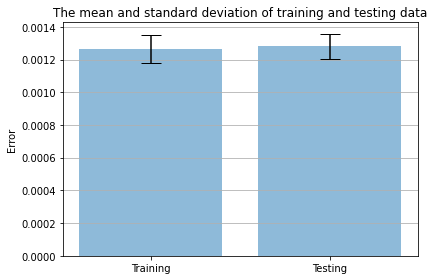

In [12]:
#plot the standard 
# Define labels, positions, bar heights and error bar heights
labels = ['Training', 'Testing']
x_pos = np.arange(len(labels))
means = [np.mean(train_errors)/100, np.mean(test_errors)/100]
stds = [np.std(np.divide(train_errors, 100)), np.std(np.divide(test_errors, 100))]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means,
       yerr=stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('The mean and standard deviation of training and testing data')
ax.yaxis.grid(True)

# show the plot
plt.tight_layout()
plt.show()